<a href="https://colab.research.google.com/github/minnji88/DeepLearning2020/blob/master/8_2%20%EB%94%A5%EB%93%9C%EB%A6%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall keras
!pip uninstall tensorflow

# !pip install keras==2.2.5
# !pip install tensorflow==1.15.0

!pip install keras==2.3.1
!pip install tensorflow==2.2

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3
Uninstalling tensorflow-2.4.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.4.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 378k

In [7]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

2.2.0
2.3.1


딥드림(DeepDream) 은 합성곱 신경망이 학습한 표현을 사용하여 예술적으로 이미지를 조작하는 기법입니다.

- 딥드림에서 특정 필터가 아니라 전체 층의 활성화를 최대화합니다. 한꺼번에 많은 특성을 섞어 시각화합니다.
- 빈 이미지나 노이즈가 조금 있는 입력이 아니라 이미 가지고 있는 이미지를 사용합니다. 그 결과 기존 시각 패턴을 바탕으로 이미지의 요소를 다소 예술적인 스타일로 왜곡시킵니다.
- 입력 이미지는 시각 품질을 높이기 위해 여러 다른 스케일(옥타브(octave) : 이미지 크기를 일정한 비율로 연속적으로 줄이거나 늘리는 방식)로 처리합니다.


In [8]:
# 코드 8-8 사전 훈련된 인셉션 V3 모델 로드하기
from keras.applications import inception_v3
from keras import backend as K
import tensorflow as tf

# 모델을 훈련하지 않습니다. 이 명령은 모든 훈련 연산을 비활성화합니다
K.set_learning_phase(0)

# 합성곱 기반층만 사용한 인셉션 V3 네트워크를 만듭니다. 사전 훈련된 ImageNet 가중치와 함께 모델을 로드합니다
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [9]:
# 코드 8-9 딥드림 설정하기

# 층 이름과 계수를 매핑한 딕셔너리.
# 최대화하려는 손실에 층의 활성화가 기여할 양을 정합니다.
# 층 이름은 내장된 인셉션 V3 애플리케이션에 하드코딩되어 있는 것입니다.
# model.summary()를 사용하면 모든 층 이름을 확인할 수 있습니다
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

손실 텐서를 정의합니다. 

In [14]:
# 코드 8-10 최대화할 손실 정의하기

# 층 이름과 층 객체를 매핑한 딕셔너리를 만듭니다.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# 손실을 정의하고 각 층의 기여분을 이 스칼라 변수에 추가할 것입니다
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    # 층의 출력을 얻습니다
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # 층 특성의 L2 노름의 제곱을 손실에 추가합니다. 이미지 테두리는 제외하고 손실에 추가합니다.
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [15]:
# 코드 8-11 경사 상승법 과정
# 이 텐서는 생성된 딥드림 이미지를 저장합니다
dream = model.input

# 손실에 대한 딥드림 이미지의 그래디언트를 계산합니다
grads = K.gradients(loss, model.input)[0]

# 그래디언트를 정규화합니다(이 기교가 중요합니다)
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# 주어진 입력 이미지에서 손실과 그래디언트 값을 계산할 케라스 Function 객체를 만듭니다
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행합니다
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
# 코드 8-13 유틸리티 함수
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # 넘파이 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        # inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원합니다
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [47]:
# 코드 8-12 연속적인 스케일에 걸쳐 경사 상승법 실행하기

import numpy as np

# 하이퍼파라미터를 바꾸면 새로운 효과가 만들어집니다
step = 0.01  # 경상 상승법 단계 크기
num_octave = 3  # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4  # 스케일 간의 크기 비율
iterations = 20  # 스케일 단계마다 수행할 경사 상승법 횟수

# 손실이 10보다 커지면 이상한 그림이 되는 것을 피하기 위해 경사 상승법 과정을 중지합니다
max_loss = 10.

# 사용할 이미지 경로를 씁니다
base_image_path = '/content/drive/My Drive/COLAB/SAI/image/youjaesuck.jpg'

# 기본 이미지를 넘파이 배열로 로드합니다
img = preprocess_image(base_image_path)

# 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비합니다
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# 이 리스트를 크기 순으로 뒤집습니다
successive_shapes = successive_shapes[::-1]

# 이미지의 넘파이 배열을 가장 작은 스케일로 변경합니다
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./final_dream.png')

처리할 이미지 크기 (190, 261)
... 0 번째 손실 : 1.708192
... 1 번째 손실 : 2.1050458
... 2 번째 손실 : 2.7106688
... 3 번째 손실 : 3.3161404
... 4 번째 손실 : 3.9467127
... 5 번째 손실 : 4.45903
... 6 번째 손실 : 4.9595737
... 7 번째 손실 : 5.4342985
... 8 번째 손실 : 5.903261
... 9 번째 손실 : 6.3543315
... 10 번째 손실 : 6.756583
... 11 번째 손실 : 7.16299
... 12 번째 손실 : 7.615978
... 13 번째 손실 : 7.9711814
... 14 번째 손실 : 8.323416
... 15 번째 손실 : 8.769659
... 16 번째 손실 : 9.093835
... 17 번째 손실 : 9.4560795
... 18 번째 손실 : 9.715686
처리할 이미지 크기 (266, 365)
... 0 번째 손실 : 2.9757636
... 1 번째 손실 : 4.227837
... 2 번째 손실 : 5.2533226
... 3 번째 손실 : 6.07403
... 4 번째 손실 : 6.8890076
... 5 번째 손실 : 7.577221
... 6 번째 손실 : 8.211991
... 7 번째 손실 : 8.850566
... 8 번째 손실 : 9.389581
처리할 이미지 크기 (373, 512)
... 0 번째 손실 : 3.1175275
... 1 번째 손실 : 4.26557
... 2 번째 손실 : 5.2273636
... 3 번째 손실 : 6.137341
... 4 번째 손실 : 7.0294676
... 5 번째 손실 : 7.8239355
... 6 번째 손실 : 8.639896
... 7 번째 손실 : 9.411164


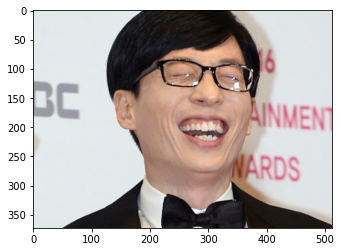

In [51]:
# 원본 이미지파일 열기 
from PIL import Image 
import matplotlib.pyplot as plt

path = './youjaesuck.jpg'
image_pil = Image.open(path)
image  = np.array(image_pil)

plt.imshow(image)
plt.show()

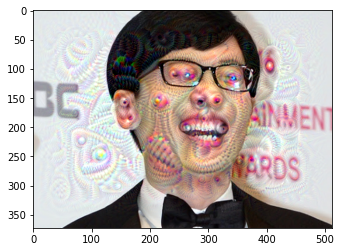

In [52]:
# 딥드림 이미지파일 열기 

path = './final_dream.png'
image_pil = Image.open(path)
image  = np.array(image_pil)

plt.imshow(image)
plt.show()

손실 층에 따라 다양한 결과가 나올 수 있습니다. 하위 층은 지역적이고 비교적 덜 추상적인 표현을 가지고 있기 때문에 딥드림 이미지에 기하학적 패턴이 많이 생깁니다. 상위층은 눈, 새의 깃털처럼 ImageNet에 많이 등장하는 물체를 기반으로 뚜렷이 구분되는 시각 패턴을 만듭니다.



재미있는 결과가 만들어지고, 때로는 환각제 때문에 시야가 몽롱해진 사람이 만든 이미지 같기도 합니다.
이미지 모델이나 컨브넷에 국한되지 않고, 음성과 음악 등에도 적용될 수 있다고 합니다.